In [1]:
import numpy as np
import cv2
import pickle, gzip, os
from matplotlib import pyplot as plt
from datetime import datetime
from typing import Any, Dict, List, Tuple

In [2]:
def save_tickle_gz(gz_path, data: Any):
    import pickle, gzip, os

    with gzip.open(gz_path, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL) # type: ignore

    # Check file existence and size
    if os.path.exists(gz_path):
        size_mb = os.path.getsize(gz_path) / (1024 * 1024)
        print(f"✅ File saved: {gz_path} ({size_mb:.2f} MB)")
    else:
        print("❌ File not found after saving.")

def load_tickle_gz(gz_path) -> dict:
    import pickle, gzip, os

    if not os.path.exists(gz_path):
        raise FileNotFoundError(f"File not found: {gz_path}")

    with gzip.open(gz_path, "rb") as f:
        data = pickle.load(f) # type: ignore

    print(f"✅ File loaded: {gz_path}.")
    return data


In [ ]:
gz_path = "TLS_DATA_2024Nov_2025May.pkl.gz"

# save_tickle_gz(gz_path, TLS_DATA)

data = load_tickle_gz(gz_path)

In [ ]:
import numpy as np

def check_xs(xs):
    xmin_list = []
    xmax_list = []
    dx_mean_list = []
    dx_std_list = []

    for i, x in enumerate(xs):
        if len(x) < 2:
            raise ValueError(f"Spectrum {i} has less than 2 points, cannot check spacing.")

        diffs = np.diff(x)
        dx_mean = np.mean(diffs)
        dx_std = np.std(diffs)

        xmin_list.append(x.min())
        xmax_list.append(x.max())
        dx_mean_list.append(dx_mean)
        dx_std_list.append(dx_std)

    # make all into a numpy array
    xmin_list = np.array(xmin_list)
    xmax_list = np.array(xmax_list)
    dx_mean_list = np.array(dx_mean_list)
    dx_std_list = np.array(dx_std_list)
    return xmin_list, xmax_list, dx_mean_list, dx_std_list

In [ ]:
xmin, xmax, dx, dx_std = check_xs(data[7]['xs'])

avg = np.mean(xmin)
std = np.std(xmin)
print(f"Average xmin: {avg / 1e9:.5}, Standard Deviation: {std / 1e9:.5} (in GHz)")

avg = np.mean(xmax)
std = np.std(xmax)
print(f"Average xmax: {avg / 1e9:.5}, Standard Deviation: {std / 1e9:.5} (in GHz)")

Average xmin: 3.1147, Standard Deviation: 0.00084981 (in GHz)
Average xmax: 4.3097, Standard Deviation: 0.00084981 (in GHz)


In [ ]:
for i in range(len(data)):
    l = set([len(x) for x in data[i]['xs']])
    print(l)

In [52]:
import numpy as np

def interpolate_to_grid(x, y, a, b, num_samples):
    """
    Interpolates y(x) onto a uniform grid from a to b (inclusive).

    Parameters:
        x (array-like): Original x values.
        y (array-like): Original y values.
        a (float): Start of interpolation interval.
        b (float): End of interpolation interval.
        num_samples (int): Number of points in the output grid.

    Returns:
        x_new (np.ndarray): Uniform grid of length `num_samples` in [a, b].
        y_new (np.ndarray): Interpolated y values on x_new.
    """
    x_new = np.linspace(a, b, num_samples)
    y_new = np.interp(x_new, x, y)
    return x_new, y_new


In [ ]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

interpolated = {}

for q, qdata in tqdm(data.items(), desc="Interpolating qubits"):
    xs = qdata['xs']
    ys = qdata['ys']

    # Determine qubit-specific interpolation range [a, b]
    x_bounds = [(x[0], x[-1]) for x in xs]
    a = max(x[0] for x in x_bounds)
    b = min(x[1] for x in x_bounds)
    x_common = np.linspace(a, b, 1200)

    def interpolate_pair(x, y):
        return np.interp(x_common, x, y)

    y_interp_list = Parallel(n_jobs=-1)(
        delayed(interpolate_pair)(x, y) for x, y in zip(xs, ys)
    )

    interpolated[q] = {
        "x_common": x_common,
        "y_interp": y_interp_list,
        "times": qdata["times"]
    }

flat_dict = {}
for q, qdata in interpolated.items():
    prefix = f"Q{q}"
    flat_dict[f"{prefix}_freq"] = qdata["x_common"]                           # shape: (1200,)
    flat_dict[f"{prefix}_s(freq, t)"] = np.vstack(qdata["y_interp"]).T        # shape: (1200, N)
    flat_dict[f"{prefix}_t"] = np.array(qdata["times"])                       # shape: (N,)

interpolated_path = "TLS_DATA/TLS_interpolated.npz"
np.savez_compressed(interpolated_path, **flat_dict)

Interpolating qubits: 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]


In [4]:
interpolated_path = "TLS_DATA/TLS_interpolated.npz"

data = np.load(interpolated_path)

# print(*list(flat_dict.keys()), sep='\n')

### Example to check interpolation

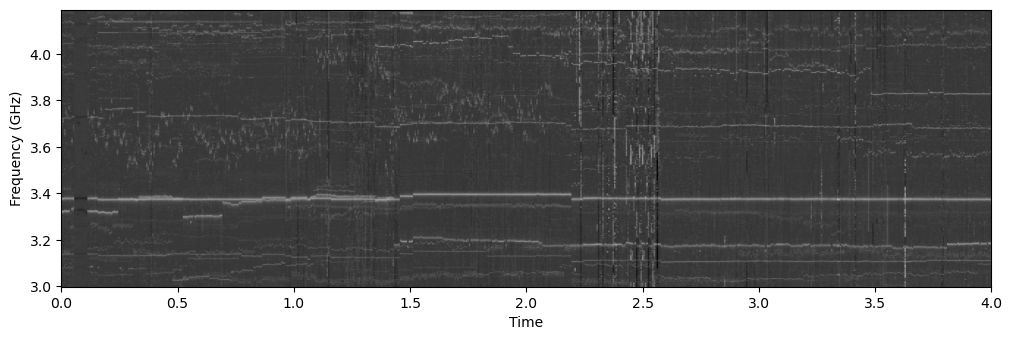

In [7]:
qid = 1
freqs = data[f"Q{qid}_freq"]          # shape: (1200,)
signal = data[f"Q{qid}_s(freq, t)"]  # shape: (1200, N)
times = data[f"Q{qid}_t"]                # shape: (N,)
dates = [datetime.strptime(t, '%a %b %d %H:%M:%S %Y').date() for t in times]

plt.figure(figsize=(12, 6))
signal = signal - np.median(signal, axis=0)
# extent is (left, right, bottom, top)
plt.imshow(signal, extent=(0, 4, freqs[0] / 1e9, freqs[-1] / 1e9), origin='lower', cmap='binary')
plt.xlabel("Time")
plt.ylabel("Frequency (GHz)")
plt.show()